In [16]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage
from scipy.stats import wasserstein_distance, binned_statistic

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *

In [3]:
df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
age = list(df['Age'])
N = len(age)
bins0 = [0, 19, 45, 65, 85, 100]
bins1 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bins2 = [0, 20, 40, 60, 80, 100]
binning = [bins0, bins1, bins2]

In [25]:
ls = []
for bins in binning:
    hist, bin_edges = np.histogram(age, bins=bins)
    distribution = hist / N
    print(distribution)

    medians, _, _ = binned_statistic(age, age, bins=bins, statistic='median')
    medians[np.isnan(medians)] = 0
    ls.append((medians, distribution))

[0.         0.82682292 0.15234375 0.02083333 0.        ]
[0.         0.         0.515625   0.21484375 0.15364583 0.07421875
 0.03776042 0.00260417 0.00130208 0.        ]
[0.         0.73046875 0.22786458 0.04036458 0.00130208]


In [15]:
d = wasserstein_distance(ls[0], ls[2])
print(d)

0.03854166666666666


In [27]:
i = 0
j = 1
d = wasserstein_distance(ls[i][0], ls[j][0], ls[i][1], ls[j][1])
print(d)

5.545572916666666


In [32]:
import json
import ast
f = open(os.path.join(ppath, 'scratch/age_partitions.json'), "r")
data = json.load(f)
f.close()
binnings = list(eval(data))
col = 'Age'
outs = []
age = list(df['Age'])
N = len(age)

data = df.copy()
data['Age.gt'] = data['Age']
df_nan = df.sample(frac=0.3, random_state=42)
data.loc[df.index.isin(df_nan.index),'Age'] = np.nan

for i in binnings:
    bins = i['bins']
    data_i = data.copy()
    data_i[col + '.binned'] = pd.cut(data_i[col], bins=bins, labels=bins[1:])
    #data_i[col + '.binned'] = data_i[col + '.binned'].astype('float64')

    imputer = KNNImputer(n_neighbors=len(bins)-1)
    data_imputed = imputer.fit_transform(data_i[col + '.binned'].values.reshape(-1, 1))
    data_imputed = np.round(data_imputed)
    data_i['Age.imputed'] = data_imputed
    data_i[col + '.final'] = pd.cut(data_i[col+'.imputed'], bins=bins, labels=bins[1:])
    data_i[col + '.final'] = data_i[col + '.final'].astype('float64')

    if len(data_i[data_i[col + '.final'].isnull()]) > 200:
        print(f"Skipping {bins}")
        continue
    #data_i['Age.final'] = data_i['Age.final'].fillna(-1)
    value_final = np.array(data_i['Age.final'].values)
    value_final[np.isnan(value_final)] = -1

    # Evaluate data imputation
    data_i['Age.gt'] = pd.cut(data_i['Age.gt'], bins=bins, labels=bins[1:])
    data_i['Age.gt'] = data_i['Age.gt'].astype('float64')
    value_gt = np.array(data_i['Age.gt'].values)
    value_gt[np.isnan(value_gt)] = -1
    #data_i['Age.gt'] = data_i['Age.gt'].fillna(-1)
    #data_i = data_i.dropna(subset=['Age.final', 'Age.gt'])
    impute_accuracy = accuracy_score(value_gt, value_final)

    #print(f"{bins}:", 1-i['gpt'], impute_accuracy)

    hist, bin_edges = np.histogram(age, bins=bins)
    distribution = hist / N

    outs.append({'bins': bins, 'distribution': distribution, 'gpt': 1-i['gpt'], 'impute_accuracy': impute_accuracy})

print(outs[0])

{'bins': [0, 19, 45, 65, 85, 100], 'distribution': array([0.        , 0.82682292, 0.15234375, 0.02083333, 0.        ]), 'gpt': 1.0, 'impute_accuracy': 0.7473958333333334}


In [68]:
# dictionary to dataframe
df_out = pd.DataFrame(outs)
# order by impute accuracy
df_out = df_out.sort_values(by='impute_accuracy', ascending=False)
df_out.to_csv(os.path.join(ppath, 'scratch/age_partitions.csv'), index=False)
# bin impute accuracy
df_out['cluster'] = pd.cut(df_out['impute_accuracy'], bins=[0, 0.7, 0.75, 0.8, 0.85, 0.9], labels=['0-0.7', '0.7-0.75', '0.75-0.8', '0.8-0.85', '0.85-0.9'])
df_out.to_csv(os.path.join(ppath, 'scratch/age_partitions.csv'), index=False)

In [47]:
df_out.groupby('cluster').size()

cluster
0-0.7        7
0.7-0.75    12
0.75-0.8     4
0.8-0.85     3
0.85-0.9     2
dtype: int64

In [79]:
i = [0.,         0.28515625, 0.69401042, 0.02083333]
j = [[0.28515625, 0.59895833, 0.11458333, 0.00130208],
     [0.,         0.515625,   0.44270833, 0.04036458, 0.00130208],
     [0.515625,   0.44270833, 0.04166667]]

print(wasserstein_distance(i, j[0]), wasserstein_distance(i, j[1]), wasserstein_distance(i, j[2]))
print(wasserstein_distance(j[2], j[1]))

print(wasserstein_distance(i, j[0],i, j[0]), wasserstein_distance(i, j[1],i, j[1]), wasserstein_distance(i, j[2],i, j[2]))
print(wasserstein_distance(j[2], j[1],j[2], j[1]))

0.047526042500000004 0.101302084 0.17252604333333335
0.13333333533333333
0.11386447954545764 0.18395996317599825 0.183959964375
0.00010512046166308608


In [67]:
from scipy.optimize import minimize

minimize(wasserstein_distance, j[0], args=(i, j[1]),method='Nelder-Mead')

ValueError: Value and weight array-likes for the same empirical distribution must be of the same size.

In [40]:
d1 = []
d2 = []
d3 = []
for i in range(len(outs)):
    d1.append(wasserstein_distance(outs[0]['distribution'], outs[i]['distribution']))
    d2.append(abs(outs[0]['impute_accuracy'] - outs[i]['impute_accuracy']))
    d3.append(outs[0]['gpt'] - outs[i]['gpt'])
    #print(outs[i]['bins'], d[-1])

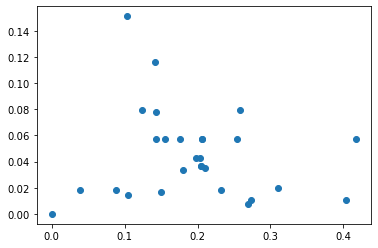

In [41]:
plt.plot(d1, d2, 'o')

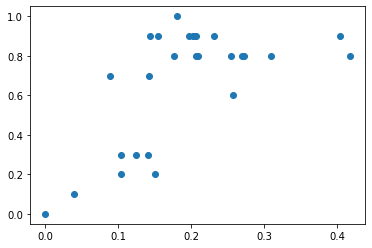

In [39]:
plt.plot(d1, d3, 'o')

ValueError: Input samples 'x' and 'y' should have the same last dimension.